In [5]:
from IPython.display import HTML
from urllib.request import urlopen

url = 'https://github.com/seynave/premiere/raw/master/custom.css'
with urlopen(url) as response:
    styles = response.read().decode("utf8")
styles = "<style>\n{}\n</style>".format(styles)
HTML(styles)

<div class="alert">
Plusieurs bibliothèques sont utilisées dans ce TP et doivent être installées. 
<ul>
   <li> Si vous travaillez directement sur le Notebook jupyter (conseillé), exécutez la cellule ci-dessous</li>
   <li>Si vous travaillez avec Thonny, il faudra installer les bibliothèques nécessaires en suivant le guide disponible sur le dépôt github.</li>
</ul>
    
</div>

In [ ]:
!python -m pip install matplotlib

# Iris : présentation de la situation

Le [jeu de données](data/iris.csv) auquel nous allons nous intéresser est un jeu de données célèbre. Il a été utilisé par Ronald Aylmer Fisher en 1936 (biologiste et statisticien) et concerne 3 espèces d'iris : setosa, virginica et versicolor. 

| Ronald Aylmer Fisher | Iris setosa | Iris virginica | Iris versicolor |
|:--------------------:|:-----------:|:--------------:|:---------------:|
| ![portrait](img/Fisher.png) | ![portrait](img/iris_setosa.jpeg) | ![portrait](img/iris_virginica.jpeg) | ![portrait](img/iris_versicolor.jpeg) |

Ce jeu de données est composé de 50 individus pour chacune des trois espèces (setosa, versicolor, virginica) soit 150 individus en tout.  


Pour chacun de ces individus on dispose des champs :
```
- id              : numéro d'échantillon (identifiant)  

- longueur_sepale : longueur des sépales  

- largeur_sepale  : largeur des sépales  

- longueur_petale : longueur des pétales  

- largeur_petale  : largeur des pétales  

- espece          : 'Iris-setosa', 'Irid_virginica' ou 'Iris-versicolor'
```

La question que se posait M. Fisher est la suivante :

**"Puis-je, à partir des longueurs et largeurs des sépales et pétales, prédire l'espèce d'un iris ?"**

On va donc chercher, à partir des quatre descripteurs `longueur_sepale, largeur_sepale, longueur_petale` et `largeur_petale`, à effectuer une prédiction de l'étiquette `espece`.

# Import de la table de données

Après exécution de la cellule de code suivante, nous disposerons grâce au module `utilitaires_iris` d'une table `table_iris` contenant les 150 enregistrements sous forme de dictionnaires,  

In [2]:
import math
import copy

from utilitaires_iris import *

#%matplotlib notebook

table_iris = charger_fichier_entete( 'iris.csv' )

<div class="question">
    
En allant voir le code de `utilitaire_iris.py` (il peut être ouvert avec Jupyter) ou en ouvrant le fichier [iris.csv](data/iris.csv) avec un **éditeur de texte** de votre choix (Atom, NotePad++), déterminer quel est le séparateur du fichier csv et quel est son encodage.  

On peut désormais accéder aux 150 enregistrements de `table_iris` :

In [3]:
table_iris[0]

{'id': '1',
 'longueur_sepale': '5.1',
 'largeur_sepale': '3.5',
 'longueur_petale': '1.4',
 'largeur_petale': '0.2',
 'espece': 'Iris-setosa'}

In [4]:
table_iris[149]

{'id': '150',
 'longueur_sepale': '5.9',
 'largeur_sepale': '3.0',
 'longueur_petale': '5.1',
 'largeur_petale': '1.8',
 'espece': 'Iris-virginica'}

<div class="question">
    
($\heartsuit $) Dans la table `table_iris`, les valeurs associées à chacun des champs sont des chaînes de caractères.  
    
Pour quels champs y aura-t-il besoin d'une conversion lorsqu'on effectuera des calculs ? **Il faudra y penser!!**

# Les 3 espèces d'iris sont-elles "séparées" les unes des autres ?

Nous avons eu l'intuition dans les exercices de cours (voir exercice 2) d'une condition "visuelle" pour que la méthode des k plus proches voisins fonctionne bien. Cette condition était qu'il est préférable que les individus ayant des étiquettes différentes soient situés dans des "zones" bien séparées.  


Nous allons rapidement visualiser ce qui se passe toujours grâce au module `utilitaires_iris`. Ce module nous permet d' afficher des projections 2D des données en choisissant deux descripteurs parmi les quatre (setosa en rouge, versicolor en vert et virginica en bleu) :

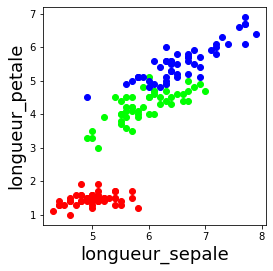

setosa : rouge, versicolor : vert, virginica : bleu


In [5]:
afficher_donnees_deux_colonnes("longueur_sepale", "longueur_petale", table_iris)

Ou bien afficher des projections 3D de ces données en choisissant trois descripteurs parmi quatre :

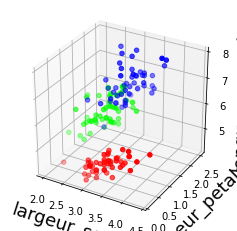

setosa : rouge, versicolor : vert, virginica : bleu


In [6]:
afficher_donnees_trois_colonnes("largeur_sepale", "largeur_petale", "longueur_sepale", table_iris)

<div class="question">
    
En modifiant les descripteurs utilisés dans les représentations graphiques ci-dessus, indiquer si les trois nuages de points classés par espèce sont bien séparés les uns des autres.   
    
    
En déduire si l'algorithme des k plus proches voisins risque de bien fonctionner ou pas.


# Implémentation de l'algorithme des k plus proches voisins

On rappelle que la formule de la distance dans le plan (en 2D) utilise les deux coordonnées $(x;y)$, dans l'espace (en 3D) utilise les trois coordonnées $(x;y;z)$ et en 4D les quatre coordonnées $(x;y;z;t)$.  

Le cas de la 4D nous est nécessaire ici puisque nous avons quatre descripteurs. Ce qui donne finalement pour deux points d'un espace 4D :

$$dist(A, B) = \sqrt{(x_B-x_A)^2 + (y_B-y_A)^2 + (z_B-z_A)^2 + (t_A-t_B)^2}$$

Chaque fonction peut être codée en moins de 5 lignes de code (vous aurez peut être des solutions plus longues : ce n'est pas grave).  


Néanmoins si vous arrivez à 20 lignes de code, c'est mauvais signe : appelez le professeur !


<div class="question">
    
Programmer ci-dessous le code d'une fonction `calculer_distance` qui :  

- prend en paramètre deux dictionnaires `iris_a` et `iris_b` ayant les quatre champs `longueur_sepale`, `largeur_sepale`, `longueur_petale`, `largeur_petale` comme ceux présents dans `table_iris`

- renvoie la distance **arrondie à trois décimales** entre ces deux iris en prenant en compte les valeurs de ces quatre champs.
 
**Rappel :**     
    
- Bien penser à la question marquée d'un ($\heartsuit$) en haut du notebook.  
    
- On utilisera la fonction `sqrt` du module `math` pour calculer la racine carrée et l'opérateur `**` pour mettre au carré.

- On utilisera `round(x, 3)` pour arrondir un nombre `x` en ne gardant que trois décimales.

In [ ]:
def calculer_distance(iris_a, iris_b):
    # A compléter

<div class="question">
    
La cellule de code ci-dessous contient 2 assertions qui permettent de tester la fonction `calculer_distance`. Exécutez ces lignes de code  : il ne faut pas d'erreur pour passer le test. Si c'est le cas, vous devez debugger le code de votre fonction

In [ ]:
iris_alpha = table_iris[7]
iris_beta = table_iris[17]

iris_a_etiqueter = {'longueur_sepale':'5.5', 
                    'largeur_sepale':'3.3', 
                    'longueur_petale':'1.1', 
                    'largeur_petale':'0.2'}

assert(calculer_distance(iris_alpha, iris_a_etiqueter) == 0.648)
assert(calculer_distance(iris_beta, iris_a_etiqueter) == 0.548)

<div class="question">
    
Programmer ci-dessous le code d'une fonction `completer_avec_distances` qui :  

- prend en paramètre :  
      
    - une table `table` (comme `table_iris`)  contenant des dictionnaires représentant des iris 
    
    - un dictionnaire `iris_a_etiqueter` représentant un iris (celui à étiqueter) 
    

- renvoie une copie de `table_iris`, copie dans laquelle on a rajouté dans chacun des enregistrements un champ `distance` (dont la valeur est la distance entre l'enregistrement et `iris_a_diagnostiquer` arrondie à 3 décimales)   
    
**Rappel :**  
    
- Pour effectuer la copie de la table on utilisera `copy.deepcopy(table)` du module `copy`. ($\spadesuit$)

In [ ]:
def completer_avec_distance(table, iris_a_etiqueter):
    # A compléter

<div class="question">
    
La cellule de code ci-dessous contient 2 assertions qui permettent de tester la fonction `completer_avec_distance`. Exécutez ces lignes de code  : il ne faut pas d'erreur pour passer le test. Si c'est le cas, vous devez debugger le code de votre fonction

In [ ]:
table_iris = charger_fichier_entete( 'data/iris.csv' )

iris_a_etiqueter = {'longueur_sepale':'5.5', 
                    'largeur_sepale':'3.3', 
                    'longueur_petale':'1.1', 
                    'largeur_petale':'0.2'}

table_completee = completer_avec_distance(table_iris, iris_a_etiqueter)

assert( table_completee[7]['distance'] == 0.648 )
assert( table_completee[17]['distance'] == 0.548 )

<div class="question">
    
Programmer ci-dessous le code d'une fonction `trier_puis_extraire` qui :  

- prend en paramètre :  
    
    - une table `table` (comme `table_completee`)  contenant des dictionnaires représentant des iris **avec en plus le champ `distance`**  
    
    - un nombre entier `k`
    
- trie la table selon la distance croissante,

- renvoie la liste des étiquettes (c'est à dire la liste des valeurs du champ `espece`) des `k` premiers iris de la table triée

**Rappel :**  
    
- Vous aurez besoin de créer une fonction `clef de tri` (voir le cours dans le bloc3).

In [ ]:
def clef_de_tri(iris):
    #A compléter

def trier_puis_extraire(table, k):
    #A compléter

In [ ]:
table_iris = charger_fichier_entete( 'data/iris.csv' )

iris_a_etiqueter = {'longueur_sepale':'6.5', 
                    'largeur_sepale':'2.8', 
                    'longueur_petale':'5.0', 
                    'largeur_petale':'1.5'}

<div class="question">
    
La cellule de code ci-dessous contient 2 assertions qui permettent de tester la fonction `trier_puis_extraire`. Exécutez ces lignes de code  : il ne faut pas d'erreur pour passer le test. Si c'est le cas, vous devez debugger le code de votre fonction

In [ ]:
table_completee = completer_avec_distance(table_iris, iris_a_etiqueter)
liste_k_etiquettes = trier_puis_extraire(table_completee, 5)
assert( liste_k_etiquettes ==  ['Iris-virginica','Iris-versicolor','Iris-versicolor',
                                'Iris-versicolor','Iris-virginica'])

table_completee = completer_avec_distance(table_iris, iris_a_etiqueter)
liste_k_etiquettes = trier_puis_extraire(table_completee, 1)
assert( liste_k_etiquettes ==  ['Iris-virginica'])

<div class="question">  
    
Pour cette question, il y a 2 façons de faire :
* Trouver sur le site [stackoverflow](https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list) en anglais une méthode très courte (en une ligne de code) pour obtenir *l'élément le plus commun présent dans une liste* et intégrez cela dans une fonction `extraire_element_majoritaire`. Vous noterez en commentaire l'URL de la page consultée.
    

* Si vous n'y arrivez pas, il est tout à fait possible d'écrire le code de la fonction `extraire_element_majoritaire` avec vos connaissances actuelles.

In [ ]:
def extraire_element_majoritaire(liste):
    #A compléter

<div class="question">
    
La cellule de code ci-dessous contient 2 assertions qui permettent de tester la fonction `extraire_element_majoritaire`. Exécutez ces lignes de code  : il ne faut pas d'erreur pour passer le test. Si c'est le cas, vous devez debugger le code de votre fonction

In [ ]:
assert(extraire_element_majoritaire(['bip', 'bip', 'blip', 'blip', 'bip']) == 'bip')
assert(extraire_element_majoritaire([1, 2, 3, 4, 5, 2, 3, 4, 5, 3, 4, 5, 4, 5, 5]) == 5)

<div class="question">   
    
Intégrez tout ce qui précède dans une unique fonction `algo_k_plus_proches_voisins` qui prend en paramètres :  
    
- un nombre entier `k`,  
    
- une table d'iris étiquetés `table_iris`,  

- et un iris non étiqueté `iris_a_etiqueter` 
    
et renvoie l'étiquette de `iris_a_etiqueter` obtenue selon l'algorithme des k plus proches voisins.

In [ ]:
def algo_k_plus_proches_voisins(k, table_iris, iris_a_etiqueter):
    #A compléter

<div class="question">
    
La cellule de code ci-dessous contient 2 assertions qui permettent de tester la fonction `completer_avec_distance`. Exécutez ces lignes de code  : il ne faut pas d'erreur pour passer le test. Si c'est le cas, vous devez debugger le code de votre fonction

In [ ]:
table_iris = charger_fichier_entete( 'data/iris.csv' )

iris_a_etiqueter = {'longueur_sepale':'6.5', 
                    'largeur_sepale':'2.8', 
                    'longueur_petale':'5.0', 
                    'largeur_petale':'1.5'}

assert(algo_k_plus_proches_voisins(5, table_iris, iris_a_etiqueter) == 'Iris-versicolor')
assert(algo_k_plus_proches_voisins(1, table_iris, iris_a_etiqueter) == 'Iris-virginica')

<div class="alert">  
    
*POINT CULTURE*
    
( $\spadesuit$ ) : Rappelons que copier une table est normalement une pratique à éviter (une table c'est potentiellement lourd donc c'est coûteux à copier).   
    
    
On le fait ici pour "alléger" le code et éviter d'avoir trop de lignes de code dans nos fonctions.   

Disons en résumé que cette mauvaise pratique (copier une table) est faite ici pour des motifs pédagogiques (aussi contradictoire que cela puisse paraître).
    

( $\spadesuit$ $\spadesuit$) Rappelons aussi que la méthode `sorted` utilisée pour trier a un avantage : elle renvoie une copie triée de la liste qui lui est fournie. La liste de départ peut donc, si on le souhaite, être laissée intacte. C'est bien car il peut arriver qu'on souhaite garder un 'original' de la liste à trier.  
    
Néanmoins c'est coûteux de recopier.  La méthode `sort` elle fait le contraire : elle modifie la liste à trier ce qui est moins coûteux (on dit qu'lle trie "en place") mais est gênant si on veut garder une trace de l'original.